In [1]:
import numpy as np
import pandas as pd
from nltk import *
import json
from keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from keras.layers import *
from keras.initializers import Constant
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Model
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import keras.backend as K

Using TensorFlow backend.


In [2]:
#import dataset
file = 'News_Category_Dataset.json'
data = pd.read_json(file, lines = True)

cats = data.groupby('category')

# We see that the categories 'THE WORLDPOST' and 'WORLDPOST' are the same. We need to combine them.
data.category = data.category.map(lambda x: 'WORLDPOST' if x =='THE WORLDPOST' else x)

# Construct a 'text' column in the dataframe that contains the headline and short descriptions
data['text'] = data.headline + ' ' + data.short_description

In [3]:
# We tokenize the text, write them into a new 'words' column.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)

T = tokenizer.texts_to_sequences(data.text)
data['words'] = T

# We neglect the entries with a short text.
data['word_length'] = data.words.apply(lambda x: len(x))
data = data[data.word_length>=5]

# We index the categories
catergories = data.groupby('category').size().index.tolist()

cat_to_int = {}
int_to_cat = {}
for i, k in enumerate(catergories):
    cat_to_int.update({k:i})
    int_to_cat.update({i:k})
    
data['cat_id'] = data['category'].apply(lambda x: cat_to_int[x])

/Users/Xuntao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# We now upload the GloVe model (50D version). Getting ready for word embedding.

EMBEDDING_DIM = 50
embedding_index = {}
f = open('/Users/Xuntao/DataScience/glove.6B.50d.txt')

for line in f:
    vector = line.split()
    word = vector[0]
    coefs = np.asarray(vector[1:], dtype = 'float32')
    embedding_index[word] = coefs
    
f.close()

# Construct the embedding matrix

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [5]:
# Construct a layer that embeds all the text using the embedding matrix above.
maxlen = 50
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [6]:
# Prepare Data

X = list(sequence.pad_sequences(data.words, maxlen = maxlen))
X = np.array(X)
Y = np_utils.to_categorical(list(data.cat_id))

# Split the training and validating sets

X_train, X_val, Y_train, Y_val = tts(X,Y, test_size = 0.2, random_state = 29)

In [7]:
#Setting up a plotting function to plot (and compare) the training histories
def train_val_ploting(my_history):
    plt.rcParams['figure.figsize'] = (6,6)

    plt.rcParams['figure.figsize'] = (6,6)

    acc = my_history.history['acc']
    val_acc = my_history.history['val_acc']
    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()

    plt.show()

In [18]:
#construct text CNN
inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1, name = 'conv'+str(kernel_size))(embedding)
    pool = MaxPooling1D(pool_size=3, name = 'maxpool'+str(kernel_size))(conv)
    drop = Dropout(0.5, name = 'dropout'+str(kernel_size))(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(catergories), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       4331400     input_5[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 50, 64)       6464        embedding_1[4][0]                
__________________________________________________________________________________________________
conv3 (Conv1D)                  (None, 50, 64)       9664        embedding_1[4][0]                
__________________________________________________________________________________________________
conv4 (Con

In [19]:
textcnn_history = TextCNN.fit(X_train, 
                              Y_train, 
                              batch_size=128, 
                              epochs=10, 
                              validation_data=(X_val, Y_val))

Train on 99254 samples, validate on 24814 samples
Epoch 1/10
99254/99254 [==============================] - 41s 417us/step - loss: 2.2185 - acc: 0.4028 - val_loss: 1.7807 - val_acc: 0.4978
Epoch 2/10
99254/99254 [==============================] - 44s 442us/step - loss: 1.8593 - acc: 0.4823 - val_loss: 1.6729 - val_acc: 0.5274
Epoch 3/10
99254/99254 [==============================] - 44s 442us/step - loss: 1.7890 - acc: 0.4996 - val_loss: 1.6317 - val_acc: 0.5376
Epoch 4/10
99254/99254 [==============================] - 41s 414us/step - loss: 1.7528 - acc: 0.5070 - val_loss: 1.6029 - val_acc: 0.5438
Epoch 5/10
99254/99254 [==============================] - 43s 431us/step - loss: 1.7302 - acc: 0.5133 - val_loss: 1.5821 - val_acc: 0.5550
Epoch 6/10
99254/99254 [==============================] - 48s 482us/step - loss: 1.7116 - acc: 0.5194 - val_loss: 1.5845 - val_acc: 0.5509
Epoch 7/10
99254/99254 [==============================] - 48s 487us/step - loss: 1.6991 - acc: 0.5228 - val_loss: 1.

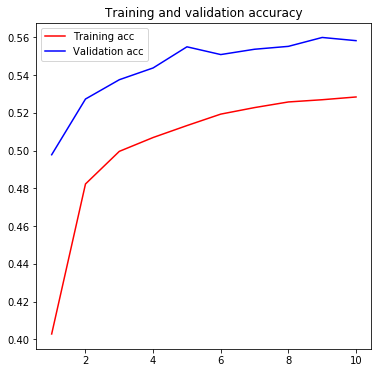

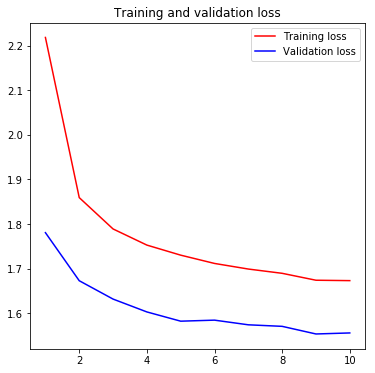

In [20]:
train_val_ploting(textcnn_history)

In [13]:
#Train with bidirectional GRU. 

inp2 = Input(shape = (maxlen,), dtype = 'int32')
x = embedding_layer(inp2)

x = SpatialDropout1D(0.5)(x)
x = Bidirectional(GRU(256, return_sequences = True, dropout=0.5, recurrent_dropout = 0.5))(x)
x = Conv1D(64, kernel_size = 3)(x)
avg_pooling = GlobalAveragePooling1D()(x)
max_pooling = GlobalMaxPooling1D()(x)

x = concatenate([avg_pooling, max_pooling])
x = Dropout(0.5)(x)
output2 = Dense(len(catergories), activation = 'softmax')(x)

BiGRU = Model(inp2, output2)
BiGRU.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

BiGRU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       4331400     input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 50, 50)       0           embedding_1[3][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 50, 512)      471552      spatial_dropout1d_4[0][0]        
__________________________________________________________________________________________________
conv1d_4 (

In [14]:
BiGRU_history = BiGRU.fit(X_train, Y_train,
                         batch_size = 128,
                         epochs = 10,
                         validation_data=(X_val, Y_val))

Train on 99254 samples, validate on 24814 samples
Epoch 1/10
99254/99254 [==============================] - 577s 6ms/step - loss: 2.5485 - acc: 0.3324 - val_loss: 1.9905 - val_acc: 0.4566
Epoch 2/10
99254/99254 [==============================] - 558s 6ms/step - loss: 2.2904 - acc: 0.3814 - val_loss: 1.8699 - val_acc: 0.4742
Epoch 3/10
99254/99254 [==============================] - 561s 6ms/step - loss: 2.1862 - acc: 0.4016 - val_loss: 1.7440 - val_acc: 0.5042
Epoch 4/10
99254/99254 [==============================] - 610s 6ms/step - loss: 2.1252 - acc: 0.4165 - val_loss: 1.6848 - val_acc: 0.5213
Epoch 5/10
99254/99254 [==============================] - 578s 6ms/step - loss: 2.0888 - acc: 0.4225 - val_loss: 1.6617 - val_acc: 0.5265
Epoch 6/10
99254/99254 [==============================] - 566s 6ms/step - loss: 2.0580 - acc: 0.4320 - val_loss: 1.6382 - val_acc: 0.5315
Epoch 7/10
99254/99254 [==============================] - 565s 6ms/step - loss: 2.0316 - acc: 0.4385 - val_loss: 1.6015 - 

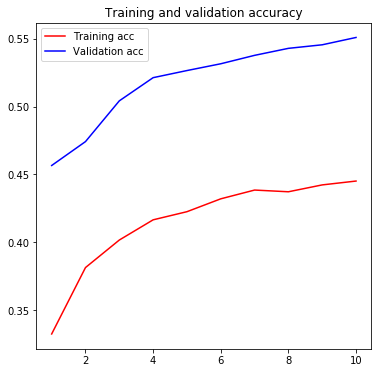

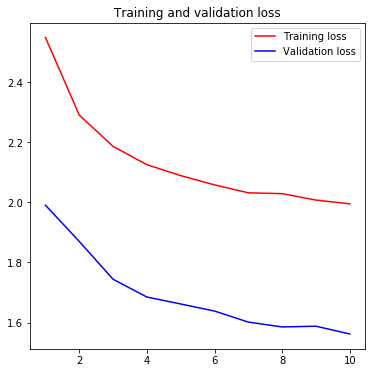

In [15]:
train_val_ploting(BiGRU_history)

In [11]:
# Bidirectional LSTM
inp3 = Input(shape = (maxlen,), dtype = 'int32')
x = embedding_layer(inp3)

x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(256, return_sequences = True, dropout=0.5, recurrent_dropout = 0.5))(x)
x = Conv1D(64, kernel_size = 3)(x)
avepool = GlobalAveragePooling1D()(x)
maxpool = GlobalMaxPooling1D()(x)

x = concatenate([avepool, maxpool])
x = Dropout(0.5)(x)
output3 = Dense(len(catergories), activation = 'softmax')(x)

BiLSTM = Model(inputs = inp3, outputs = output3)
BiLSTM.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

BiLSTM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       4331400     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 50, 50)       0           embedding_1[2][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 50, 512)      628736      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv1d_3 (

In [12]:
BiLSTM_history = BiLSTM.fit(X_train, Y_train, 
                            batch_size = 128, epochs = 10, 
                            validation_data = (X_val, Y_val)) 

Train on 99254 samples, validate on 24814 samples
Epoch 1/10
99254/99254 [==============================] - 702s 7ms/step - loss: 2.5036 - acc: 0.3402 - val_loss: 1.9596 - val_acc: 0.4543
Epoch 2/10
99254/99254 [==============================] - 725s 7ms/step - loss: 2.2376 - acc: 0.3932 - val_loss: 1.8028 - val_acc: 0.4902
Epoch 3/10
99254/99254 [==============================] - 705s 7ms/step - loss: 2.1253 - acc: 0.4186 - val_loss: 1.7267 - val_acc: 0.5112
Epoch 4/10
99254/99254 [==============================] - 692s 7ms/step - loss: 2.0602 - acc: 0.4333 - val_loss: 1.6704 - val_acc: 0.5243
Epoch 5/10
99254/99254 [==============================] - 687s 7ms/step - loss: 2.0218 - acc: 0.4408 - val_loss: 1.6105 - val_acc: 0.5401
Epoch 6/10
99254/99254 [==============================] - 5556s 56ms/step - loss: 1.9909 - acc: 0.4498 - val_loss: 1.5868 - val_acc: 0.5465
Epoch 7/10
99254/99254 [==============================] - 695s 7ms/step - loss: 1.9727 - acc: 0.4560 - val_loss: 1.5578 

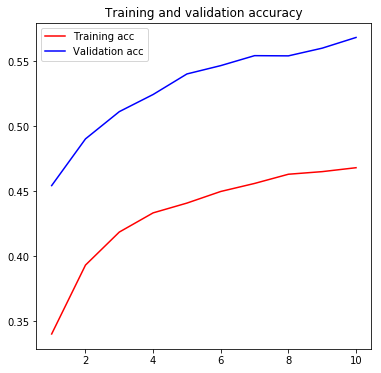

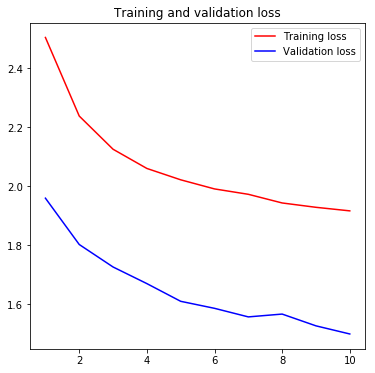

In [16]:
train_val_ploting(BiLSTM_history)